# Import

In [8]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from IPython.display import display

In [2]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Dataset

- Store - id магазина
- Date - Начало недели
- Weekly_Sales - недельные продажи
- Holiday_Flag - были праздниики за выходные или нет
- Temperature - температура
- Fuel_Price - цена топлива в регионе
- CPI - Действующий индекс потребительских цен
- Unemployment - уровень безработицы
  

In [20]:
df = pd.read_csv("data/Walmart.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [22]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [ ]:
df['Store'].unique()

45

In [30]:
df['log_sales'] = np.log(df['Weekly_Sales'])

In [31]:
df.groupby('Store').agg(
    mean_sales=('log_sales', 'mean'),
    row_cnt=('Date', 'count')
).sort_values('mean_sales', ascending=False)

,mean_sales,row_cnt
Store,,
20,14.554115,143
4,14.548294,143
14,14.508292,143
13,14.503566,143
2,14.464736,143
10,14.447419,143
27,14.381419,143
6,14.255502,143
1,14.252679,143


<Axes: >

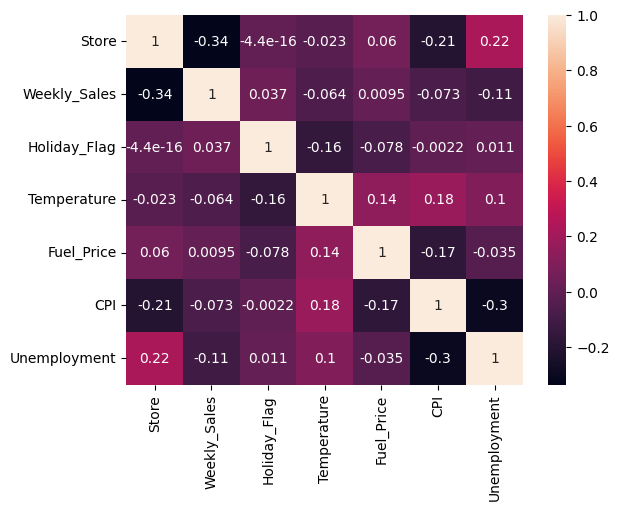

In [24]:
sns.heatmap(df.corr(numeric_only=True), annot=True, )

In [7]:
df.describe()

,avg_temperature_C,wind_speed_mps,solar_radiation_kWh_m2,humidity_percent,altitude_m,installation_cost_usd,maintenance_cost_usd_year,output_efficiency_percent,optimized_output_kw
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,29.966212,7.755127,4.508147,55.093330,1494.370580,30011.939830,1150.115990,67.534852,254.933357
std,8.659263,4.180785,1.438994,20.511423,867.028165,11531.282362,490.469428,15.880974,141.168066
min,15.000000,0.500000,2.000000,20.000000,0.000000,10000.000000,300.000000,40.000000,10.010000
25%,22.500000,4.120000,3.270000,37.000000,745.000000,20000.000000,726.000000,53.770000,132.695000
50%,29.900000,7.760000,4.520000,55.000000,1490.000000,30024.000000,1149.000000,67.560000,255.350000
75%,37.400000,11.370000,5.750000,73.000000,2244.000000,39998.250000,1575.000000,81.290000,376.640000
max,45.000000,15.000000,7.000000,90.000000,3000.000000,50000.000000,2000.000000,95.000000,500.000000


In [10]:
for name, x in df.groupby('source_type'):
    print(name)
    display(x.describe())

biomass


,avg_temperature_C,wind_speed_mps,solar_radiation_kWh_m2,humidity_percent,altitude_m,installation_cost_usd,maintenance_cost_usd_year,output_efficiency_percent,optimized_output_kw
count,33150.000000,33150.000000,33150.000000,33150.000000,33150.000000,33150.000000,33150.000000,33150.000000,33150.000000
mean,29.996615,7.736986,4.507971,55.177768,1490.011161,30134.747149,1152.939336,67.472482,254.297025
std,8.692346,4.169420,1.439416,20.530953,868.195097,11497.544473,489.916189,15.878535,141.273524
min,15.000000,0.500000,2.000000,20.000000,0.000000,10000.000000,300.000000,40.000000,10.050000
25%,22.500000,4.110000,3.270000,37.000000,737.000000,20157.250000,731.000000,53.660000,131.912500
50%,29.950000,7.750000,4.520000,55.000000,1485.000000,30217.000000,1151.500000,67.430000,254.440000
75%,37.500000,11.330000,5.750000,73.000000,2244.000000,40041.750000,1577.000000,81.260000,376.150000
max,45.000000,15.000000,7.000000,90.000000,3000.000000,50000.000000,2000.000000,95.000000,500.000000


solar


,avg_temperature_C,wind_speed_mps,solar_radiation_kWh_m2,humidity_percent,altitude_m,installation_cost_usd,maintenance_cost_usd_year,output_efficiency_percent,optimized_output_kw
count,33172.000000,33172.000000,33172.000000,33172.000000,33172.000000,33172.000000,33172.000000,33172.000000,33172.000000
mean,29.942093,7.769225,4.511925,55.047118,1499.757114,29955.885355,1149.205474,67.529818,254.946684
std,8.661051,4.177027,1.441231,20.542744,868.090211,11535.673216,492.904637,15.920062,141.048919
min,15.000000,0.500000,2.000000,20.000000,0.000000,10001.000000,300.000000,40.000000,10.010000
25%,22.400000,4.150000,3.270000,37.000000,753.000000,19928.500000,719.000000,53.657500,133.012500
50%,29.900000,7.780000,4.530000,55.000000,1496.000000,29928.500000,1149.000000,67.710000,255.365000
75%,37.400000,11.400000,5.760000,73.000000,2250.000000,39941.500000,1580.000000,81.270000,375.910000
max,45.000000,15.000000,7.000000,90.000000,3000.000000,50000.000000,2000.000000,95.000000,499.980000


wind


,avg_temperature_C,wind_speed_mps,solar_radiation_kWh_m2,humidity_percent,altitude_m,installation_cost_usd,maintenance_cost_usd_year,output_efficiency_percent,optimized_output_kw
count,33678.000000,33678.000000,33678.000000,33678.000000,33678.000000,33678.000000,33678.000000,33678.000000,33678.000000
mean,29.960042,7.759097,4.504598,55.055734,1493.356048,29946.270147,1148.233743,67.601201,255.546587
std,8.624976,4.195689,1.436406,20.461609,864.827114,11559.460084,488.607698,15.844996,141.182978
min,15.000000,0.500000,2.000000,20.000000,0.000000,10000.000000,300.000000,40.000000,10.020000
25%,22.500000,4.110000,3.270000,37.000000,747.000000,19910.000000,729.000000,54.000000,133.220000
50%,29.900000,7.775000,4.500000,55.000000,1486.000000,29981.500000,1147.000000,67.540000,256.205000
75%,37.400000,11.370000,5.750000,73.000000,2239.000000,39993.000000,1569.750000,81.320000,378.040000
max,45.000000,15.000000,7.000000,90.000000,3000.000000,50000.000000,2000.000000,95.000000,500.000000
